In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

# Dessinez vos applications - Projet Python ENSAE 2A

Par Solène Cochennec et Pierre Delanoue 

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Mise à disposition des données 

In [3]:
import numpy as np
import cv2
from PIL import Image

from glob import glob
import os

%matplotlib inline
import matplotlib.pyplot as plt

### Chargement des données 

In [4]:
imPath = "Database/All_pictures/"
ls_path = glob(os.path.join(imPath, '*' ))

images_base_vide=[]
label_nom_vide=[]

for file in ls_path: 
    im = np.array(Image.open(file))[:,:,3]   
    images_base_vide+=[im]
    label_nom_vide+=[file.split('/')[2].split('_')[0]]   
images_base_raw=np.array(images_base_vide)
label_nom_raw=np.array(label_nom_vide)

In [5]:
def print_exemple_image(num_image,X=images_base_raw,y=label_nom_vide) :
    plt.imshow(X[num_image],cmap='Greys')
    plt.suptitle("Image n°"+str(num_image)+" : "+str(y[num_image]), fontsize=20)
   

In [6]:
from sklearn.model_selection import train_test_split


In [7]:
ramdom_seed_fixée=5

def get_split_classique() :
    return train_test_split(images_base_raw, label_nom_raw, test_size=0.20, random_state=ramdom_seed_fixée)

In [8]:
X_train_classique , X_test_classique , Y_train_classique , Y_test_classique = get_split_classique()

In [9]:
label_to_OneHot = {'Deezer':[1,0,0,0],'Messenger':[0,1,0,0],'Facebook':[0,0,1,0],'Tinder':[0,0,0,1]}
label_to_num = {'Deezer':0 ,'Messenger':1 ,'Facebook':2,'Tinder':3} 
num_to_label={0:'Deezer',1:'Messenger' ,2:'Facebook',3:'Tinder'}

In [10]:
def transformation_dictionnaire_image(X,Y,data_aug=1,num_pixel_cote=64) : 
    taille = X.shape[0]
    data_base={'image':[], 'data': [], 'label_num' : [],'label_OneHot' : [],'nom_label' :[]}
    for i in range(taille) : 
        im = cv2.resize(X[i], (num_pixel_cote,num_pixel_cote))
        name=Y[i]
        
        for k in range(data_aug):
            deg_rot=(k%2)*(((k+1)//2))*5+(1-k%2)*(((k+1)//2)*(-5))
            num_rows, num_cols = im.shape[:2]
            rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), deg_rot, 1)
            im_rotation = cv2.warpAffine(im, rotation_matrix, (num_cols, num_rows))
        
            
            data_base['image']+=[im_rotation]
            data_base['data']+=[np.ndarray.flatten(im_rotation)]
            data_base['label_num']+=[label_to_num[name]]
            data_base['label_OneHot']+=[label_to_OneHot[name]]
            data_base['nom_label']+=[name]
            
            
    data_base['image']=np.array( data_base['image'])
    data_base['data']=np.array(data_base['data'])
    data_base['label_num']=np.array(data_base['label_num'])
    data_base['label_OneHot']=np.array(data_base['label_OneHot'])
    data_base['nom_label']=np.array(data_base['nom_label'])
    
    return data_base
  

### Train et Test Classiques

In [11]:
num_aug_classique=7

In [12]:
Train_Classique = transformation_dictionnaire_image(X_train_classique,Y_train_classique,data_aug=num_aug_classique)
Test_Classique = transformation_dictionnaire_image(X_test_classique,Y_test_classique)

### Train et Test Progressifs

In [13]:
catégories= ['Deezer','Facebook','Messenger','Tinder']

In [14]:
X_train_progressif , X_test_progressif , Y_train_progressif , Y_test_progressif = [],[],[],[]

for cat in catégories : 
    imPath = "Database/"+cat+"/"
    ls_path = glob(os.path.join(imPath, '*' ))

    taille_train=len(ls_path)-len(ls_path)//5
    #Train
    for file in ls_path[:taille_train]: 
        im = np.array(Image.open(file))[:,:,3]   
        X_train_progressif+=[im]
        Y_train_progressif+=[file.split('/')[2].split('_')[0]]

    #Test
    for file in ls_path[taille_train:]: 
        im = np.array(Image.open(file))[:,:,3]   
        X_test_progressif+=[im]
        Y_test_progressif+=[file.split('/')[2].split('_')[0]]
    

X_train_progressif=np.array(X_train_progressif)
Y_train_progressif=np.array(Y_train_progressif)
X_test_progressif=np.array(X_test_progressif)
Y_test_progressif=np.array(Y_test_progressif)

In [15]:
num_aug_progressif=7

In [16]:
Train_Progressif = transformation_dictionnaire_image(X_train_progressif,Y_train_progressif,data_aug=num_aug_progressif)
Test_Progressif = transformation_dictionnaire_image(X_test_progressif,Y_test_progressif)

### Le jeu de données qu'on utilise ici

In [17]:
Train_dic=Train_Classique
Test_dic=Test_Classique

In [18]:
# Nombre pixel coté
img_size = Train_dic['image'].shape[1]

# Nombre de pixel au total
img_size_flat = Train_dic['data'].shape[1]

# Nombre de pixel longeur et largeur 
img_shape = Train_dic['image'].shape[1:]

# Nombre de classes (si on ajoute de nouveaux logos)
num_classes = 4 

## Modèles avec Scikit-Learn

In [19]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns; sns.set()



In [20]:
def matrice_de_confusion_ML(ypredx,name):

    mat = confusion_matrix(Test_dic['label_num'], ypredx)
    sns.heatmap(mat.T, cmap="Blues", square=True, annot=True)

    plt.title('Matrice de confusion - '+name, y=1.05, size=15)

    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, [num_to_label[i] for i in range(num_classes)])
    plt.yticks(tick_marks, [num_to_label[i] for i in range(num_classes)])
    plt.xlabel('Vraie')
    plt.ylabel('Prédite')

### Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression

In [22]:
regr = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') 
regr.fit(Train_dic['data'], Train_dic['label_num']) 
ypred_ML1 = regr.predict(Test_dic['data'])

In [23]:
print(metrics.classification_report(ypred_ML1, Test_dic['label_num']))

             precision    recall  f1-score   support

          0       0.54      0.41      0.47        82
          1       0.34      0.41      0.37        64
          2       0.38      0.36      0.37        86
          3       0.44      0.51      0.47        71

avg / total       0.43      0.42      0.42       303



In [24]:
print(metrics.accuracy_score(ypred_ML1, Test_dic['label_num']))

0.41914191419141916


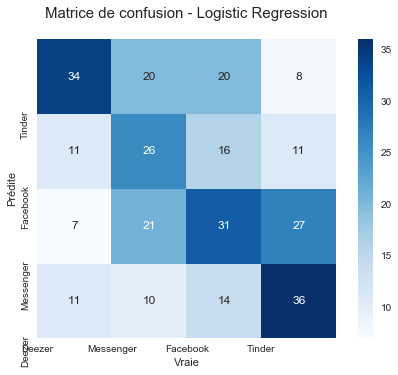

In [25]:
matrice_de_confusion_ML(ypred_ML1 , 'Logistic Regression')

### One vs. All

In [26]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

In [27]:
OVR= OneVsRestClassifier(LinearSVC(random_state=0))
OVR.fit(Train_dic['data'], Train_dic['label_num']) 
ypred_ML5 = OVR.predict(Test_dic['data'])

In [28]:
print(metrics.classification_report(ypred_ML5, Test_dic['label_num']))

             precision    recall  f1-score   support

          0       0.49      0.37      0.42        83
          1       0.27      0.39      0.32        54
          2       0.44      0.40      0.42        90
          3       0.44      0.47      0.46        76

avg / total       0.43      0.41      0.41       303



In [29]:
print(metrics.accuracy_score(ypred_ML5, Test_dic['label_num']))

0.40924092409240925


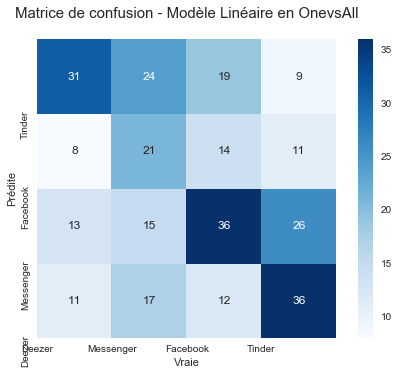

In [30]:
matrice_de_confusion_ML(ypred_ML5 , 'Modèle Linéaire en OnevsAll')

### Arbre de décision

In [31]:
from sklearn.tree import DecisionTreeClassifier


In [32]:
Decision = DecisionTreeClassifier()
Decision.fit(Train_dic['data'], Train_dic['label_num'])
ypred_ML2 = Decision.predict(Test_dic['data'])

In [33]:
print(metrics.classification_report(ypred_ML2, Test_dic['label_num']))

'             precision    recall  f1-score   support\n\n          0       0.43      0.38      0.40        71\n          1       0.34      0.36      0.35        72\n          2       0.46      0.43      0.44        86\n          3       0.37      0.41      0.38        74\n\navg / total       0.40      0.40      0.40       303\n'

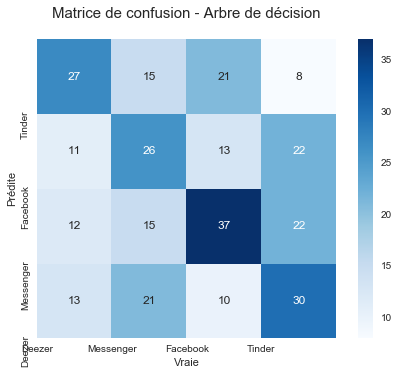

In [34]:
matrice_de_confusion_ML(ypred_ML2 , 'Arbre de décision')

### Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(Train_dic['data'],Train_dic['label_num'])
ypred_ML3 = model.predict(Test_dic['data'])

C:\Users\Delanoue\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [36]:
accuracy_score(ypred_ML3, Test_dic['label_num'])

0.504950495049505

In [37]:
print(metrics.classification_report(ypred_ML3, Test_dic['label_num']))

'             precision    recall  f1-score   support\n\n          0       0.67      0.51      0.58        83\n          1       0.31      0.55      0.40        44\n          2       0.58      0.44      0.50       107\n          3       0.49      0.58      0.53        69\n\navg / total       0.54      0.50      0.51       303\n'

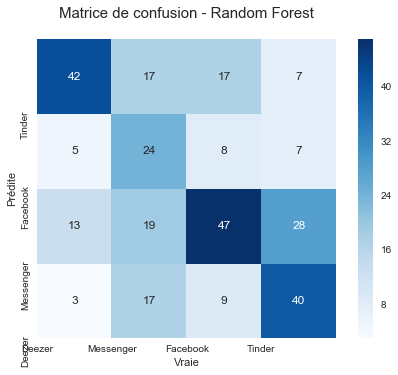

In [38]:
matrice_de_confusion_ML(ypred_ML3 , 'Random Forest')

### AdaBoost

In [39]:
from sklearn.ensemble import AdaBoostClassifier

In [40]:
AdaBoost = AdaBoostClassifier()
AdaBoost.fit(Train_dic['data'], Train_dic['label_num']) 
ypred_ML4 = AdaBoost.predict(Test_dic['data'])

In [41]:
print(metrics.classification_report(ypred_ML4, Test_dic['label_num']))

             precision    recall  f1-score   support

          0       0.49      0.48      0.49        64
          1       0.14      0.28      0.19        40
          2       0.38      0.39      0.39        80
          3       0.70      0.48      0.57       119

avg / total       0.50      0.43      0.45       303



In [42]:
print(metrics.accuracy_score(ypred_ML4, Test_dic['label_num']))

0.429042904290429


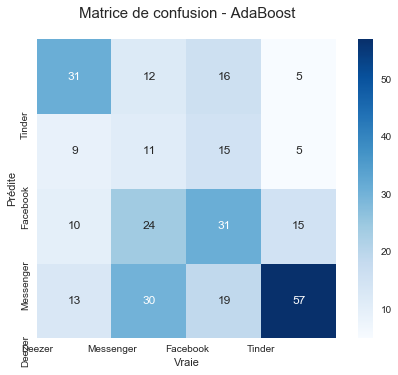

In [43]:
matrice_de_confusion_ML(ypred_ML4 , 'AdaBoost')

## Modèles avec Tensorflow

In [ ]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import random

### Informations utiles 

### Fonctions que l'on va utiliser plusieurs fois 

In [ ]:
def plot_image(image):
    
    plt.imshow(image.reshape(img_shape), interpolation='nearest',cmap='binary')
    plt.show()

In [ ]:
def plot_9_images(images, cls_vrai, cls_pred=None):
    assert len(images) == len(cls_vrai) == 9

    fig, axes = plt.subplots(3, 3,  figsize=(10,5))
    fig.subplots_adjust(hspace=0.3, wspace=0.1)

    for i, ax in enumerate(axes.flat):
        
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        if cls_pred is None:
            xlabel = "True: {0}".format(cls_vrai[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_vrai[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

In [ ]:
images = Train_dic['image'][0:9]
cls_vrai = [num_to_label[i] for i in Train_dic['label_num'][0:9]]


plot_9_images(images=images, cls_vrai=cls_vrai)

In [ ]:
def get_random_batch(X,y,batch_size) :
    index=random.sample(range(1,y.shape[0]), batch_size)
    return X[index], y[index]

In [ ]:
def exemples_erreurs():
    
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],feed_dict=feed_dict_test)

    incorrect = (correct == False)
    images = Test_dic['data'][incorrect]
    
    cls_pred = cls_pred[incorrect]
    cls_vrai = Test_dic['label_num'][incorrect]
    
    plot_9_images(images=images[0:9],
                cls_vrai=[num_to_label[i] for i in cls_vrai[0:9]],
                cls_pred=[num_to_label[i] for i in cls_pred[0:9]])

In [ ]:
def matrice_de_confusion():

    cls_true = Test_dic['label_num']
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
    
    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)

    print(cm)


    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, [num_to_label[i] for i in range(num_classes)])
    plt.yticks(tick_marks, [num_to_label[i] for i in range(num_classes)])
    plt.xlabel('Prédite')
    plt.ylabel('Vraie')
    
    plt.show()

In [ ]:
def print_accuracy():

    acc = session.run(accuracy, feed_dict=feed_dict_test)

    print("Accuracy sur Test set: {0:.1%}".format(acc))

### Modèle linéaire simple

### MLS - Construction des variables 

In [ ]:
x = tf.placeholder(tf.float32, [None, img_size_flat])

In [ ]:
y_true = tf.placeholder(tf.float32, [None, num_classes])

In [ ]:
y_true_cls = tf.placeholder(tf.int64, [None])

In [ ]:
poids = tf.Variable(tf.zeros([img_size_flat, num_classes]))

In [ ]:
biases = tf.Variable(tf.zeros([num_classes]))

In [ ]:
logits = tf.matmul(x, poids) + biases

In [ ]:
y_pred = tf.nn.softmax(logits)

In [ ]:
y_pred_cls = tf.argmax(y_pred, axis=1)

In [ ]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                           labels=y_true)

In [ ]:
cost = tf.reduce_mean(cross_entropy)

In [ ]:
optimizer_mls = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

In [ ]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [ ]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
session = tf.Session()

In [ ]:
session.run(tf.global_variables_initializer())

In [ ]:
batch_size = 100

In [ ]:
def optimize_mls(num_iterations):
    for i in range(num_iterations):
        x_batch, y_true_batch = get_random_batch(Train_dic['data'],Train_dic['label_OneHot'],batch_size)

        feed_dict_train = {x: x_batch, y_true: y_true_batch}

        session.run(optimizer_mls, feed_dict=feed_dict_train)

In [ ]:
def visualisation_poids():
    
    w = session.run(poids)
 
    w_min = np.min(w)
    w_max = np.max(w)

    fig, axes = plt.subplots(2, 2)


    for i, ax in enumerate(axes.flat):

        image = w[:, i].reshape(img_shape)
        ax.set_xlabel("Poids: {0}".format(num_to_label[i]))
        ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

In [ ]:
feed_dict_test = {x: Test_dic['data'], y_true: Test_dic['label_OneHot'], y_true_cls: Test_dic['label_num']}

In [ ]:
print_accuracy()

In [ ]:
exemples_erreurs()

In [ ]:
optimize_mls(num_iterations=1)

In [ ]:
print_accuracy()

In [ ]:
visualisation_poids()

In [ ]:
optimize_mls(num_iterations=9)

In [ ]:
print_accuracy()

In [ ]:
visualisation_poids()

In [ ]:
optimize_mls(num_iterations=990)

In [ ]:
print_accuracy()

In [ ]:
visualisation_poids()

In [ ]:
matrice_de_confusion()

In [ ]:
session.close()

### Réseau neuronal convolutif  (Convolutional Neural Network)

In [ ]:
tf.reset_default_graph()

In [ ]:
# Premier convolutional Layer.
filter_size1 = 5          # Filtre de 5 x 5 pixels.
num_filters1 = 16         # Il y a ici 16 filtres.

# Deuxième convolutional Layer
filter_size2 = 5          # Filtre de 5 x 5 pixels.
num_filters2 = 36         # Il y a ici 36 filtres .

# Couche fully connected 
fc_size = 128             # Nombre de neuronnes dans la dernière couche 

# Noir et blanc ? 1 si oui 
num_channels = 1

In [ ]:
def crea_poids(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def nouveau_biais(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [ ]:
def new_conv_layer(input,
                   num_input_channels,
                   filter_size,
                   num_filters,
                   use_pooling=True):

    shape = [filter_size, filter_size, num_input_channels, num_filters]

    weights = crea_poids(shape=shape)

    biases = nouveau_biais(length=num_filters)

    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    layer += biases

    if use_pooling:

        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    layer = tf.nn.relu(layer)

    return layer, weights

In [ ]:
def flatten_layer(layer):

    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])

    return layer_flat, num_features

In [ ]:
def new_fc_layer(input,          
                 num_inputs,     
                 num_outputs,    
                 use_relu=True): 

  
    weights = crea_poids(shape=[num_inputs, num_outputs])
    biases = nouveau_biais(length=num_outputs)
    layer = tf.matmul(input, weights) + biases
    
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [ ]:
def plot_conv_weights(weights, input_channel=0):

    w = session.run(weights)
    w_min = np.min(w)
    w_max = np.max(w)
    num_filters = w.shape[3]
    num_grids = math.ceil(math.sqrt(num_filters))
    fig, axes = plt.subplots(num_grids, num_grids)

    for i, ax in enumerate(axes.flat):

        if i<num_filters:

            img = w[:, :, input_channel, i]
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')

        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

In [ ]:
def plot_conv_layer(layer, image):

    feed_dict = {x: [image]}
    values = session.run(layer, feed_dict=feed_dict)
    num_filters = values.shape[3]
    num_grids = math.ceil(math.sqrt(num_filters))
    fig, axes = plt.subplots(num_grids, num_grids)


    for i, ax in enumerate(axes.flat):

        if i<num_filters:
            img = values[0, :, :, i]
            ax.imshow(img, interpolation='nearest', cmap='binary')
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

#### CNN - Construction des varaibles 

In [ ]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

In [ ]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

In [ ]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

In [ ]:
y_true_cls = tf.argmax(y_true, axis=1)

In [ ]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

In [ ]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

In [ ]:
layer_flat, num_features = flatten_layer(layer_conv2)

In [ ]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

In [ ]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [ ]:
y_pred = tf.nn.softmax(layer_fc2)

In [ ]:
y_pred_cls = tf.argmax(y_pred, axis=1)

In [ ]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)

In [ ]:
cost = tf.reduce_mean(cross_entropy)

In [ ]:
optimizer_cnn = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

In [ ]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [ ]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
session = tf.Session()

In [ ]:
session.run(tf.global_variables_initializer())

In [ ]:
train_batch_size = 64

In [ ]:
total_iterations = 0
batch_size=100

def optimize_cnn(num_iterations):
    
    global total_iterations
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        x_batch, y_true_batch = get_random_batch(Train_dic['data'],Train_dic['label_OneHot'],batch_size)


        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        session.run(optimizer_cnn, feed_dict=feed_dict_train)

        if i % 100 == 0:

            acc = session.run(accuracy, feed_dict=feed_dict_train)
            msg = "Nombre d'Optimisation : {0:>6}, Accuracy sur Train set: {1:>6.1%}"
            print(msg.format(i + 1, acc))

    total_iterations += num_iterations
    end_time = time.time()
    time_dif = end_time - start_time

    print("Temps d'usage: " + str(timedelta(seconds=int(round(time_dif)))))

#### CNN - Résultats

In [ ]:
feed_dict_test = {x: Test_dic['data'],
                  y_true: Test_dic['label_OneHot'],
                  y_true_cls: Test_dic['label_num']}

In [ ]:
print_accuracy()

In [ ]:
optimize_cnn(num_iterations=1)

In [ ]:
print_accuracy()

In [ ]:
for i in range(10): 
    optimize_cnn(num_iterations=100) 
    print_accuracy()

In [ ]:
matrice_de_confusion()

In [ ]:
exemples_erreurs()


In [ ]:
image1 = Test_dic['data'][24]
plot_image(image1)

In [ ]:
image2 = Test_dic['data'][19]
plot_image(image2)

In [ ]:
plot_conv_weights(weights=weights_conv1)

In [ ]:
plot_conv_layer(layer=layer_conv1, image=image1)

In [ ]:
plot_conv_layer(layer=layer_conv1, image=image2)

In [ ]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

In [ ]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

In [ ]:
plot_conv_layer(layer=layer_conv2, image=image1)   

In [ ]:
plot_conv_layer(layer=layer_conv2, image=image2)

In [ ]:
session.close()